# Santander Customer Transaction Prediction
From the Kaggle competition:
https://www.kaggle.com/c/santander-customer-transaction-prediction/code

This notebook explores the data and tries to build efficient pipelines for transforming the data, 
and applying various models. Those pipelines allow to run multiple iterations of the model, chosing the best performing one.
Models' performance is evaluated using accuracy metrics, tested on the k-fold cross validated datasets.

The notebook is still in progress, even though the competition has finished, it will used for various experiments and aiming to improve the modelling techiques or testing novelty algorithms' performance.

<b>The notebook relies heavily on my two created programs for feature engineering.</b>

Those can be found in the same folder:

Lasso_FeatureSelection_Pipeline.py

RandomForest_FeatureSelection_Pipeline.py



-----------



### Importing libraries

In [1]:
# basic
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import os
import sys
import math 
import sklearn as s
import scipy as sc
import statsmodels as st
import random
from random import randint

# preprocessing and pipelines
import joblib as jb
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn_pandas import DataFrameMapper #to map specific colummns before passing to training
import sklearn_pandas

# models tried
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
import catboost
from xgboost import XGBClassifier
import xgboost
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
# presentation
from IPython.display import display
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import mlxtend
import keras

# interpretation
import eli5
import shap



import time

# Custom classes
import Lasso_FeatureSelection_Pipeline as lfp
import RandomForest_FeatureSelection_Pipeline as rfp

# packages versisons for requirements 
print("Numpy version:")
print(np.__version__)
print("Pandas version:")
print(pd.__version__)
print("Sklearn version:")
print(s.__version__)
print("Scipy version:")
print(sc.__version__)
print("Statsmodel version:")
print(st.__version__)
print("Joblib version:")
print(jb.__version__)
print("Catboost version:")
print(catboost.__version__)
print("LGB version:")
print(lgb.__version__)
print("XGBoost version:")
print(xgboost.__version__)
print("sklearn_pandas version:")
print(sklearn_pandas.__version__)
print("mlxtend version:")
print(mlxtend.__version__)
print("keras version:")
print(keras.__version__)
print("eli5 version:")
print(eli5.__version__)
print("shap version:")
print(shap.__version__)







PATH = ''  #change if required
OUTPUT = ''
SEED=777

Numpy version:
1.19.5
Pandas version:
1.2.3
Sklearn version:
0.24.2
Scipy version:
1.6.2
Statsmodel version:
0.12.2
Joblib version:
1.0.1
Catboost version:
0.26
LGB version:
3.2.1
XGBoost version:
1.3.3
sklearn_pandas version:
2.2.0
mlxtend version:
0.18.0
keras version:
2.5.0
eli5 version:
0.11.0
shap version:
0.39.0


### Reading and exploring the data 

In [2]:
df = pd.read_csv('train.csv')
df.columns.tolist()

['ID_code',
 'target',
 'var_0',
 'var_1',
 'var_2',
 'var_3',
 'var_4',
 'var_5',
 'var_6',
 'var_7',
 'var_8',
 'var_9',
 'var_10',
 'var_11',
 'var_12',
 'var_13',
 'var_14',
 'var_15',
 'var_16',
 'var_17',
 'var_18',
 'var_19',
 'var_20',
 'var_21',
 'var_22',
 'var_23',
 'var_24',
 'var_25',
 'var_26',
 'var_27',
 'var_28',
 'var_29',
 'var_30',
 'var_31',
 'var_32',
 'var_33',
 'var_34',
 'var_35',
 'var_36',
 'var_37',
 'var_38',
 'var_39',
 'var_40',
 'var_41',
 'var_42',
 'var_43',
 'var_44',
 'var_45',
 'var_46',
 'var_47',
 'var_48',
 'var_49',
 'var_50',
 'var_51',
 'var_52',
 'var_53',
 'var_54',
 'var_55',
 'var_56',
 'var_57',
 'var_58',
 'var_59',
 'var_60',
 'var_61',
 'var_62',
 'var_63',
 'var_64',
 'var_65',
 'var_66',
 'var_67',
 'var_68',
 'var_69',
 'var_70',
 'var_71',
 'var_72',
 'var_73',
 'var_74',
 'var_75',
 'var_76',
 'var_77',
 'var_78',
 'var_79',
 'var_80',
 'var_81',
 'var_82',
 'var_83',
 'var_84',
 'var_85',
 'var_86',
 'var_87',
 'var_88',
 'var_89

In [3]:
import re #removing column names special characters, since those are not allowed in boosts libs

df = df.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))
df = df.rename(columns={"target": "Class"})

In [4]:
df.dtypes.value_counts()

float64    200
int64        1
object       1
dtype: int64

In [5]:
df.select_dtypes(include=['object'])

,ID_code
0,train_0
1,train_1
2,train_2
3,train_3
4,train_4
...,...
199995,train_199995
199996,train_199996
199997,train_199997
199998,train_199998


In [6]:
drop = ['ID_code']

# df_2014.loc[:, ~df_2014.columns.isin([categ])]

df = df.loc[:, ~df.columns.isin(drop)]

df

,Class,var_0,var_1,var_2,var_3,var_4,var_5,var_6,var_7,var_8,...,var_190,var_191,var_192,var_193,var_194,var_195,var_196,var_197,var_198,var_199
0,0,8.9255,-6.7863,11.9081,5.0930,11.4607,-9.2834,5.1187,18.6266,-4.9200,...,4.4354,3.9642,3.1364,1.6910,18.5227,-2.3978,7.8784,8.5635,12.7803,-1.0914
1,0,11.5006,-4.1473,13.8588,5.3890,12.3622,7.0433,5.6208,16.5338,3.1468,...,7.6421,7.7214,2.5837,10.9516,15.4305,2.0339,8.1267,8.7889,18.3560,1.9518
2,0,8.6093,-2.7457,12.0805,7.8928,10.5825,-9.0837,6.9427,14.6155,-4.9193,...,2.9057,9.7905,1.6704,1.6858,21.6042,3.1417,-6.5213,8.2675,14.7222,0.3965
3,0,11.0604,-2.1518,8.9522,7.1957,12.5846,-1.8361,5.8428,14.9250,-5.8609,...,4.4666,4.7433,0.7178,1.4214,23.0347,-1.2706,-2.9275,10.2922,17.9697,-8.9996
4,0,9.8369,-1.4834,12.8746,6.6375,12.2772,2.4486,5.9405,19.2514,6.2654,...,-1.4905,9.5214,-0.1508,9.1942,13.2876,-1.5121,3.9267,9.5031,17.9974,-8.8104
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,0,11.4880,-0.4956,8.2622,3.5142,10.3404,11.6081,5.6709,15.1516,-0.6209,...,6.1415,13.2305,3.9901,0.9388,18.0249,-1.7939,2.1661,8.5326,16.6660,-17.8661
199996,0,4.9149,-2.4484,16.7052,6.6345,8.3096,-10.5628,5.8802,21.5940,-3.6797,...,4.9611,4.6549,0.6998,1.8341,22.2717,1.7337,-2.1651,6.7419,15.9054,0.3388
199997,0,11.2232,-5.0518,10.5127,5.6456,9.3410,-5.4086,4.5555,21.5571,0.1202,...,4.0651,5.4414,3.1032,4.8793,23.5311,-1.5736,1.2832,8.7155,13.8329,4.1995
199998,0,9.7148,-8.6098,13.6104,5.7930,12.5173,0.5339,6.0479,17.0152,-2.1926,...,2.6840,8.6587,2.7337,11.1178,20.4158,-0.0786,6.7980,10.0342,15.5289,-13.9001


In [7]:
df.Class.value_counts(normalize = True)

0    0.89951
1    0.10049
Name: Class, dtype: float64

In [8]:
y = df['Class'].values
X = df.copy()
del X['Class']

In [9]:
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

## Correlation Matrix

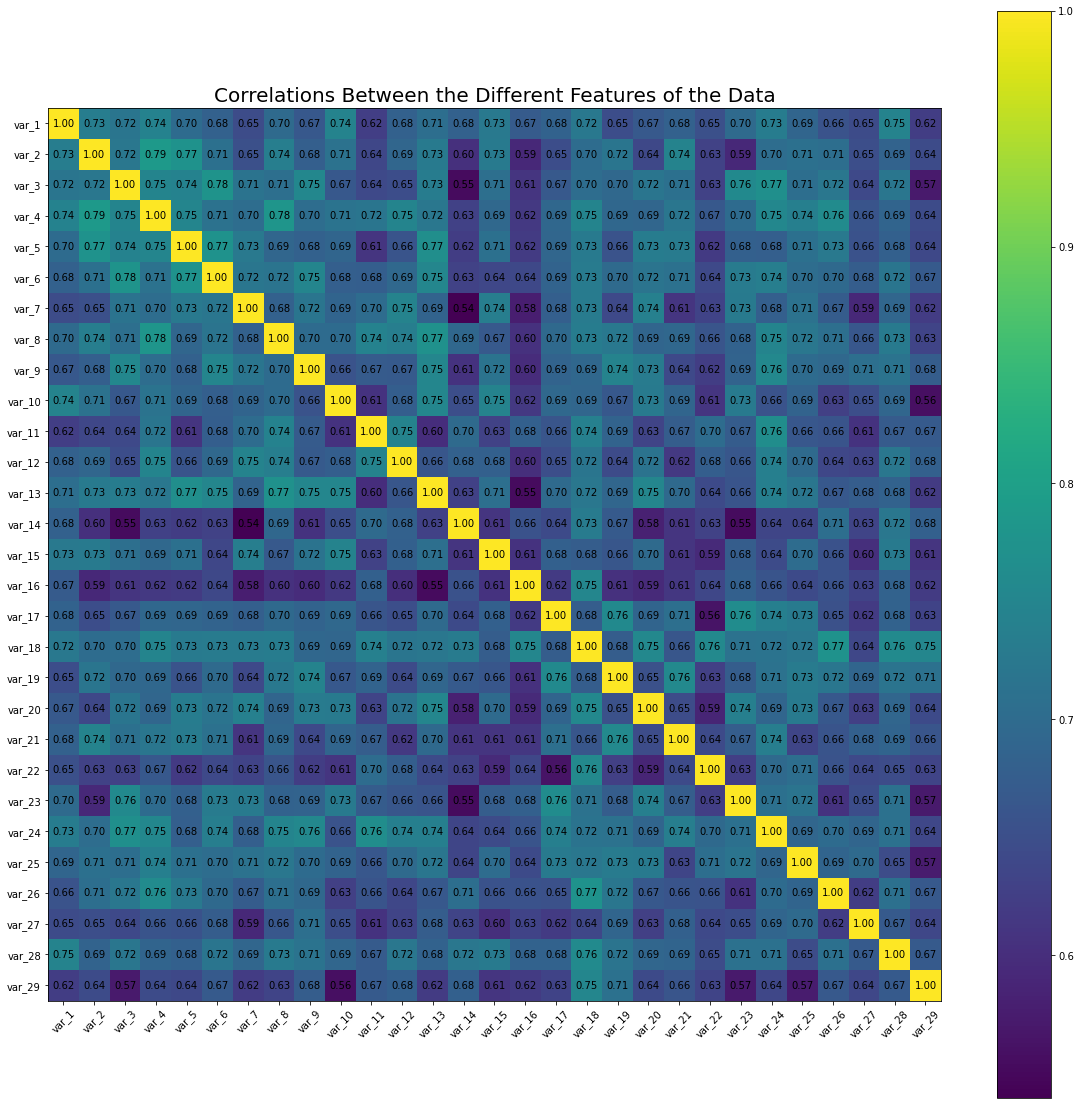

In [10]:
# Plot correlation matrix
from mlxtend.plotting import heatmap

# cm = np.corrcoef(np.hstack([X_test[:10000]], y_test[:10000]).T)
# cm = np.corrcoef(np.hstack([X_test[:10000][1:30]]).T)
cm = np.corrcoef(X_test[:10000][1:30])
cols = list(X_test[:10000].columns[1:30])
hm = heatmap(cm, row_names = cols, column_names = cols, figsize = (20, 20))
plt.title('Correlations Between the Different Features of the Data', fontsize = 20)
plt.show()

## Applying my Lasso module, to include bespoke generator for the sklearn pipeline 
#### Please see Lasso_FeatureSelection_Pipeline.py

In [11]:
n = int(df.shape[0] / 2)
lassofe = lfp.LassoFeatureSelectionPipeline(df[:n], df[n:],0)

()


In [12]:
# Uncomment this when running final version - heavy to run
lassofe.model()

Running feature engineering....
50%


,C,AUC,Number of features
0,0.001,0.782119,65
1,0.005,0.857959,166
2,0.008,0.860097,174
3,0.010,0.860651,181
4,0.020,0.861360,191
5,0.050,0.861646,199
6,0.070,0.861665,199
7,0.080,0.861672,199
8,0.100,0.861706,200
9,0.150,0.861715,200


In [13]:
lasso_features = lassofe.model(0.10)

Running feature engineering....


## Applying my Random Forest module, to include bespoke generator for the sklearn pipeline 
#### Please see RandomForest_FeatureSelection_Pipeline.py

In [14]:
rforestfe = rfp.RandomForestFeatureSelectionPipeline(df[:n], df[n:],  100, max_depth = 1)

In [15]:
# Uncomment this when running final version - heavy to run
rforestfe.model()


Running feature engineering....
Performing accuracy tests
Feature engineering completed.


,Number of features,AUC
0,20,0.685401
1,40,0.707789
2,100,0.726726
3,140,0.747210
4,200,0.755149


In [16]:
# Uncomment this when running final version - normally heavy to run
rf_features = rforestfe.model(topvalues = 100)

Running feature engineering....
Performing accuracy tests
Feature engineering completed.


In [17]:
# for developement: THINK HOW YOU CAN INCORPORATE CATEGORICAL SECTOR VARIABLE 
# FOR NOW SECTOR IS EXCLUDED 

## Creating Transformer Pipeline

In [18]:
pipeline_transformer = Pipeline(steps = [
       ('imputer', SimpleImputer(strategy='median')),  # fill Missing value

    
])

additional_variable_transform = "Not Implemented"
df_cat_feats = []

numer = df.columns.tolist()

numer.remove('Class')


In [19]:
preprocessor = ColumnTransformer(
        transformers=[
            ('num', pipeline_transformer, numer),
#             ('cat', additional_variable_transform, df_cat_feats)
        ], n_jobs=1)

## Creating Lasso Preprocessor Pipeline

In [20]:
current_columns = X_train.columns.tolist()

preprocessor_pipe_lasso = Pipeline(steps = [('preprocessor', preprocessor),
                                            ('lasso', lfp.LassoPipelineProcessor(savedfeatures_names = lasso_features,
                                                                                current_features = current_columns))
    
])

In [21]:
# preprocessor_pipe_lasso.fit()

## Creating Random Forest Preprocessor Pipeline

In [22]:
preprocessor_pipe_rf = Pipeline(steps = [('preprocessor', preprocessor),
                                            ('lasso', rfp.RandomForestProcessor(savedfeatures_names = rf_features,
                                                                                current_features = current_columns))
    
])

# Pipelines
##### Here the pipelines for all models are created and applied.
##### Model performance is mainly assessed using AUC.

In [23]:
#from sklearn.linear_model import LogisticRegression
model_pipeline_lgb = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
                                 
                                 ('light_gradint_boosting',  lgb.LGBMClassifier(boosting_type='gbdt', random_state=SEED, n_jobs=1,learning_rate=0.01,subsample=0.8
                                       , colsample_bytree=0.74, max_depth=20 ,num_leaves=30 ,n_estimators=800, min_child_samples=35 ,min_split_gain=0.4))
                                 ])
# fit the pipeline with the training data
model_pipeline_lgb.fit(X_train,y_train)

# predict target values on the training data

probclf_lgb=[]
for a, b in model_pipeline_lgb.predict_proba(X_test):
    probclf_lgb.append(b)
    


auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)



AUC: 0.8653800309676555
Gini: 0.730760061935311


In [24]:
model_pipeline_xgb = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
                                 
#                                  ('Xtra_gradint_boosting',  XGBClassifier(max_depth=5, learning_rate=0.02, n_estimators=600,min_child_weight=3,reg_alpha=6, seed=0,
#                           scale_pos_weight =1,gamma=.6,random_state=77)    ),
                                     
                                     ('Xtraboost', XGBClassifier(verbosity= 0,
          objective= 'reg:pseudohubererror',
          eval_metric= 'mae',
          subsample= 0.8,
          colsample_bytree= 0.8,
          # 'tree_method': 'gpu_hist',
          eta= 0.1,
          max_depth= 5,
           gamma= 0,
         min_child_weight= 1))
                                    ])

model_pipeline_xgb.fit(X_train,y_train)
probclf_lgb=[]
for a, b in model_pipeline_lgb.predict_proba(X_test):
    probclf_lgb.append(b)

auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)



AUC: 0.8653800309676555
Gini: 0.730760061935311


In [25]:
from sklearn.linear_model import LogisticRegression


model_pipeline_lr = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
                                 
                                 ('logistic_reg', LogisticRegression(C=0.1))
                                 ])

model_pipeline_lr.fit(X_train,y_train)
probclf_lgb=[]
for a, b in model_pipeline_lr.predict_proba(X_test):
    probclf_lgb.append(b)

auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)



AUC: 0.8493869530768988
Gini: 0.6987739061537976


In [26]:
from sklearn.ensemble import RandomForestClassifier

model_pipeline_rf = Pipeline(steps=[
    
#     (('preprocessorPipe', preprocessor_pipe_lasso)), 
                                    
                                    (('rfpreprocessorPipe', preprocessor_pipe_rf)), 
                                 
#                                  ('random_forest', RandomForestClassifier(max_depth=3,random_state=22,bootstrap=False,max_features='sqrt'
#                                                                          ,min_samples_leaf=4,min_samples_split=10,n_estimators=800)),
                                    
                                ('random_forest', RandomForestClassifier(max_depth=1,random_state=22,
                                                                        min_samples_leaf=2,min_samples_split=2))
                                 ])
model_pipeline_rf.fit(X_train,y_train)
probclf_lgb=[]
for a, b in model_pipeline_rf.predict_proba(X_test):
    probclf_lgb.append(b)

auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)




AUC: 0.7162700165419661
Gini: 0.4325400330839322


In [27]:
model_pipeline_cat = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
                                 
('catboost',   
                                  
                                  CatBoostClassifier(n_estimators=1000,
                          learning_rate=0.04,task_type='CPU',random_seed=SEED
                          ,depth=7,loss_function='MultiClass',silent=True,grow_policy='SymmetricTree'
                                     ,eval_metric='AUC'      )    )                                
                                    ])

model_pipeline_cat.fit(X_train,y_train)
probclf_lgb=[]
for a, b in model_pipeline_cat.predict_proba(X_test):
    probclf_lgb.append(b)

auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)



AUC: 0.8928733842212175
Gini: 0.7857467684424351


In [28]:
from keras.models import Sequential
from keras.layers import Dense, Dropout

model = Sequential()

# model.add(Dropout(0.1, noise_shape=None, seed=None))

model.add(Dense(300, activation='relu'))
# model.add(Dropout(0.1, noise_shape=None, seed=None))

model.add(Dense(300, activation='relu'))
model.add(Dense(200, activation='relu'))

model.add(Dense(200, activation='relu'))


model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])


model_pipeline_NN = Pipeline(steps = [ (('preprocessorPipe', preprocessor_pipe_lasso)), 
                                      
(('model', model))
])

# changed to 1 for current run, since more epochs did not beat tree models 
model_pipeline_NN.fit(X_train,y_train, model__epochs = 50)


probclf_lgb=[]
for b in model_pipeline_NN.predict_proba(X_test):
    probclf_lgb.append(b)

auc = roc_auc_score(y_test, probclf_lgb)

print('AUC:', auc)
print('Gini:', 2*auc-1)



Epoch 1/50
5000/5000 [==============================] - 24s 2ms/step - loss: 0.3069 - accuracy: 0.8983
Epoch 2/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2554 - accuracy: 0.9075
Epoch 3/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2535 - accuracy: 0.9081
Epoch 4/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2499 - accuracy: 0.9084
Epoch 5/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2477 - accuracy: 0.9089
Epoch 6/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2444 - accuracy: 0.9110
Epoch 7/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2454 - accuracy: 0.9100
Epoch 8/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2437 - accuracy: 0.9114
Epoch 9/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.2437 - accuracy: 0.9109
Epoch 10/50
5000/5000 [==============================] - 8s 2ms/step - loss: 0.24

# Parameters tuning

In [29]:
# Picked 3 best performing models to tune parameters
xgb = XGBClassifier()
# lgb = lgb.LGBMClassifier(boosting_type='gbdt', random_state=SEED)
ctb = CatBoostClassifier()

crossvalpipe1 = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
                               ('xgboost_crossval', xgb)
                              ])

# crossvalpipe2 = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
#                                ('lgboost_crossval', lgb)
#                               ])
# crossvalpipe3 = Pipeline(steps=[(('preprocessorPipe', preprocessor_pipe_lasso)), 
#                                ('catboost_crossval', ctb)
#                               ])
param1 = {
    'xgboost_crossval__max_depth': [None, 1, 2, 3], 
         'xgboost_crossval__n_estimators':[50, 70, 100, 500, 600], 
          'xgboost_crossval__criterion' : ['gini', 'entropy'],
          'xgboost_crossval__bootstrap':[True, False],
#           'xgboost_crossval__min_samples_leaf': randint(1,4),
         'xgboost_crossval__gamma' : [0, 0.1, 0.2, 0.5]
}
param2 = {
    'max_depth': [1,2, 3], 
         'n_estimators':[50, 70, 100, 500, 600], 
          'max_features': randint(1,6),
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
          'mln_samples_leaf': randint(1,4),
         'gamma' : [0, 0.1, 0.2, 0.5]}
param3 = {'max_depth': [1,2, 3], 
         'n_estimators':[50, 70, 100, 500, 600, 1000], 
          'max_features': randint(1,6),
          'criterion' : ['gini', 'entropy'],
          'bootstrap':[True, False],
          'mln_samples_leaf': randint(1,4),
         'learning_rate' : [0.01,0.001,0.04,0.02, 0.1, 0.2, 0.5]}

                        

In [30]:
# All below under developement
# This is currently a bit heavy to run on my CPU, should be used only for experimentations 

# rnd_search = RandomizedSearchCV(crossvalpipe1, param1, 
# n_iter =10, cv=5)
# rnd_search.fit(X,y)

In [31]:
# rnd_search.best_params_

In [32]:
# rnd_search.best_score_

In [33]:
# additional validation on final chosen model : cross validation 

# Develop model:

## Interpretability 
Credits to: https://www.kaggle.com/ashishpatel26/interpretability-of-ml-black-box-model-iml

#### ELI5 module

In [36]:
#  https://eli5.readthedocs.io/en/latest/overview.html
from eli5.sklearn import PermutationImportance
perm = PermutationImportance(model_pipeline_xgb, random_state = 1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())


Weight,Feature
0.0004 ± 0.0002,var_81
0.0004 ± 0.0001,var_80
0.0004 ± 0.0001,var_26
0.0003 ± 0.0002,var_12
0.0003 ± 0.0002,var_148
0.0003 ± 0.0001,var_164
0.0002 ± 0.0000,var_76
0.0002 ± 0.0001,var_115
0.0002 ± 0.0002,var_22
0.0002 ± 0.0003,var_174


#### SHAP module

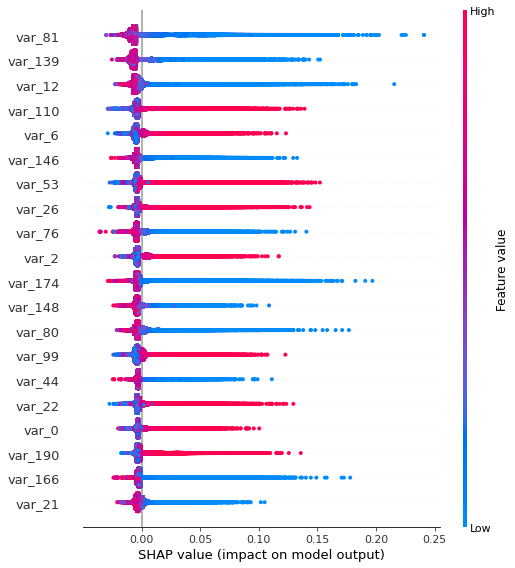

In [37]:
from IPython.display import Image
import matplotlib.pyplot as plt
import shap
# Shap values show how much a given feature 
# changed our prediction (compared to if we made that prediction at some baseline value of that feature).
# Good article about SHAP : https://towardsdatascience.com/interpretable-machine-learning-with-xgboost-9ec80d148d27
modelxboosttemp = XGBClassifier(verbosity= 0,
          objective= 'reg:pseudohubererror',
          eval_metric= 'mae',
          subsample= 0.8,
          colsample_bytree= 0.8,
          # 'tree_method': 'gpu_hist',
          eta= 0.1,
          max_depth= 5,
           gamma= 0,
         min_child_weight= 1)
modelxboosttemp.fit(X_train,y_train)
explainer = shap.TreeExplainer(modelxboosttemp)
# Calculate Shap values
shap_values = explainer.shap_values(X_train)
shap.initjs()
shap.summary_plot(shap_values, X_train)


In [38]:
data_for_prediction = xgboost.DMatrix(X_train.iloc[[10],:])  # use 1 row of data here. Could use multiple rows if desired
# print(f"The 85th data is predicted to be True's probability: {model.predict(data_for_prediction)}")
shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])


In [39]:
# data_for_prediction = xgboost.DMatrix(X_train.iloc[[10],:])  # use 1 row of data here. Could use multiple rows if desired
# print(f"The 85th data is predicted to be True's probability: {modelxboosttemp.predict(data_for_prediction)}")
# # shap.force_plot(explainer.expected_value, shap_values[10,:], X_train.iloc[10,:])

data_for_prediction = xgboost.DMatrix(X_train.iloc[[10],:])
shap.force_plot(explainer.expected_value, shap_values[83,:], X_train.iloc[83,:])


In [ ]:
shap.force_plot(explainer.expected_value, shap_values, X_train)


In [ ]:
#To be developed further